In [80]:
import numpy as np
import matplotlib.pyplot as plt

In [81]:
A = np.array([[.95,.05],[.1,.9]])
B = np.array([[1./6.,1./6.,1./6.,1./6.,1./6.,1./6.],[.1,.1,.1,.1,.1,.5]])

Algorithmie
======
On va intensivement utiliser les fonctions `np.cumsum` et `np.searchsorted`. On pourrait s'amuser à les recoder nous même mais ce n'est pas le but de ce TP

In [82]:
premiereLigneB = B[0,:]
print(premiereLigneB)
premiereLigneSommee = np.cumsum(premiereLigneB)
print("on applique la function cumsum on a :"+str(premiereLigneSommee))
tirageNbAleatoire1 = np.random.rand()
tirageNbAleatoire2 = np.random.rand()
tirageNbAleatoire3 = np.random.rand()
print("on a tire 3 nombres : "+str((tirageNbAleatoire1,tirageNbAleatoire2,tirageNbAleatoire3)))
print("maintenant regardons le resultat de searchsorted :"+str((np.searchsorted(premiereLigneSommee,tirageNbAleatoire1),np.searchsorted(premiereLigneSommee,tirageNbAleatoire2),np.searchsorted(premiereLigneSommee,tirageNbAleatoire3))))


[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
on applique la function cumsum on a :[0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ]
on a tire 3 nombres : (0.8652731260941176, 0.13116673041569737, 0.2211231197386767)
maintenant regardons le resultat de searchsorted :(5, 0, 1)


> 1. **Expliquez** avec vos mots quels à quoi servent ces fonctions.
> 2. **Comment** pourrions nous nous en servir ?

=> Votre réponse ici <=

In [83]:
def dc(A,B,Pdepart,nEtat):
    etat = []
    valeurDuJeu = []
    etatDebut = 1 if np.random.rand() < Pdepart[0] else 2
    etat += [etatDebut]
    De1somme = np.cumsum(B[0,:])
    De2somme = np.cumsum(B[1,:])
    valAleat = np.random.rand()
    valeurDebut = np.searchsorted(De1somme,valAleat)+1 if etat[-1] == 1 else np.searchsorted(De2somme,valAleat)+1
    valeurDuJeu += [valeurDebut]
    n = 1
    T1Somme = np.cumsum(A[0,:])
    T2Somme = np.cumsum(A[1,:])
    while n < nEtat:
        valAleatEtat = np.random.rand()
        etatCourant = np.searchsorted(T1Somme,valAleatEtat) +1 if etat[-1] == 1 else np.searchsorted(T2Somme,valAleatEtat)+1
        etat += [etatCourant]
        valAleat = np.random.rand()
        valeurDe = np.searchsorted(De1somme,valAleat)+1 if etat[-1] == 1 else np.searchsorted(De2somme,valAleat)+1
        valeurDuJeu += [valeurDe]
        n += 1
    return np.array(etat),np.array(valeurDuJeu)
    

In [84]:
pdepart = np.array([.5,.5])
etats, valDes = dc(A,B,pdepart,100)
print(etats,valDes)

(array([2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1]), array([3, 6, 6, 6, 5, 1, 3, 5, 6, 2, 6, 3, 1, 5, 1, 2, 5, 2, 5, 6, 6, 4,
       6, 6, 3, 2, 3, 5, 6, 2, 6, 5, 4, 5, 5, 1, 1, 4, 4, 5, 4, 5, 4, 4,
       6, 1, 1, 6, 6, 6, 2, 2, 5, 1, 6, 4, 1, 1, 1, 3, 2, 6, 1, 3, 6, 3,
       6, 6, 6, 6, 3, 6, 6, 2, 6, 5, 3, 1, 3, 5, 5, 3, 3, 6, 6, 5, 3, 2,
       2, 4, 4, 2, 2, 3, 4, 6, 6, 5, 6, 6]))


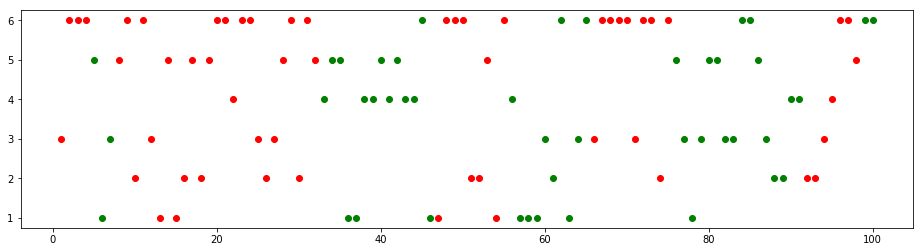

In [85]:
# petit affichage des familles
plt.figure(figsize=(16,4))
etat1Indexes = np.where(etats == 1)[0]
plt.plot(etat1Indexes+1,valDes[etat1Indexes],'og')
etat2Indexes = np.where(etats==2)[0]
plt.plot(etat2Indexes+1,valDes[etat2Indexes],'or')
plt.show()


## Algo Viterbi
à partir du pseudo code : 
https://en.wikipedia.org/wiki/Viterbi_algorithm

In [86]:
# pi intial distribution ici pdepart
# y observation ici valDes
def Viterbi(pi,y,A,B):
    Tobserv = y.size
    K = A.shape[0]
    N = B.shape[1]
    T1 = np.zeros((K,Tobserv))
    T2 = np.zeros((K,Tobserv))
    for i in range(K):
        T1[i,0]=pi[i]*B[i,y[0]-1]
        T2[i,0]=pi[i]*B[i,y[0]-1]
    def takeDaMaxAndArg(T1,A,B,i,yi,j,K):
        indMax = -1
        currentMaximum = -42
        for k in range(K):
            value = T1[k]*A[k,j]*B[j,yi]
            if value > currentMaximum :
                currentMaximum = value
                indMax = k
        return currentMaximum,indMax
        
    for i in range(Tobserv-1):
        for j in range(K):
            maxi,arg = takeDaMaxAndArg(T1[:,i],A,B,i,y[i+1]-1,j,K)
            T1[j,i+1] = maxi
            T2[j,i+1] = arg
    Z = np.zeros(Tobserv)
    Z[-1] = int(np.argmax(T1[:,-1]))
    for i in range(Z.shape[0]-1,0,-1):
        Z[i-1] = T2[int(Z[i]),i]
    
    return Z
    
    

In [87]:
etatsGuessed = Viterbi(pdepart,valDes,A,B)

In [88]:
print(etatsGuessed)

[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 1.]
